In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, Longitude, Latitude
import astropy.units as u
from astropy.time import Time
from astropy.table import Table, vstack

import matplotlib.pylab as plt
from read_ybc import readYBC

from astropy.coordinates import SkyCoord
from astropy import units as u

import lsst.all_sky_phot.wcs as asp
from scipy.optimize import minimize

from astropy.coordinates import match_coordinates_sky

from lsst.all_sky_phot import readcr2

from phot_night import phot_files
from wcs_utils import apply_wcs_to_photometry, match_catalog, radec2altaz, trim_stars, robustRMS
from photutils import CircularAperture
from lsst.all_sky_phot.wcs import wcs_refine

from lsst.all_sky_phot.wcs import fit_xyshifts, Fisheye

In [2]:
# Load the Yale bright star catalog
ybc = readYBC()

In [3]:
# Load up a frame and do photometry on it
#filename = 'ut012716/ut012716.0130.long.cr2'
filename = 'ut012516/ut012516.0322.long.cr2'
im, header = readcr2(filename)
sum_image = np.sum(im, axis=2).astype(float)
phot_tables = phot_files([filename], savefile=None)
phot_appertures = CircularAperture( (phot_tables[0]['xcenter'], phot_tables[0]['ycenter']), r=5.)
zp = -18.
measured_mags = -2.5*np.log10(phot_tables[0]['residual_aperture_sum'].data) - zp

reading image
background
finding sources
doing photometry
progress = 0.00%

In [4]:
# the simple wcs based on just identified stars
hdulist = fits.open('wcs_asp_only.fits')
wcs_simple = wcs.WCS(hdulist[0].header)
hdulist.close()

In [5]:
# OK, let's see where we expect the stars to be
lsst_location = EarthLocation(lat=-30.2444*u.degree, lon=-70.7494*u.degree, height=2650.0*u.meter)
alt, az = radec2altaz(ybc['RA'], ybc['Dec'], header['mjd'], location=lsst_location)
good = np.where(alt > 5.)
alt = alt[good]
az = az[good]

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
If you need enough precisi

In [6]:
xg, yg, xo, yo, npts, ds = fit_xyshifts(phot_tables[0]['xcenter'].value, phot_tables[0]['ycenter'].value,
                              alt, az, wcs_simple)
#xs, yx, nn = fit_xyshifts(phot_tables[0]['xcenter'].value, phot_tables[0]['ycenter'].value,
#                         alt, az, wcs_simple)

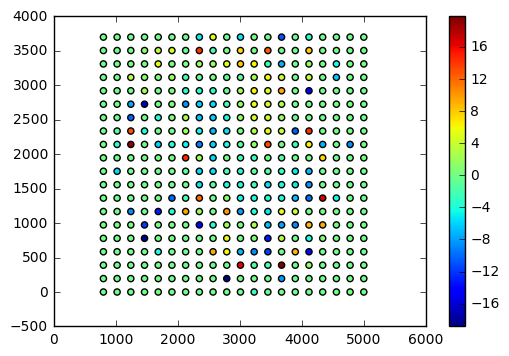

In [7]:
plt.scatter(xg.ravel(), yg.ravel(), c=xo)
plt.colorbar()

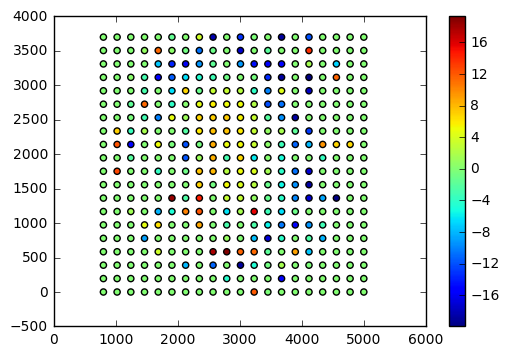

In [8]:
plt.scatter(xg.ravel(), yg.ravel(), c=yo)
plt.colorbar()

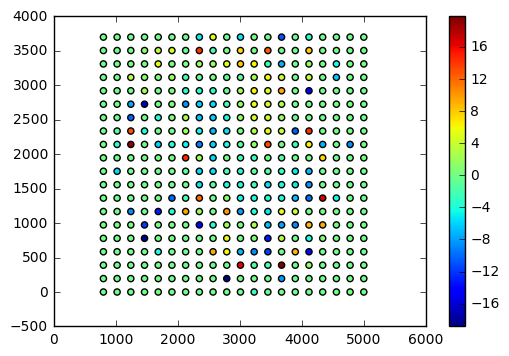

In [9]:
plt.scatter(xg.ravel(), yg.ravel(), c=xo)
plt.colorbar()

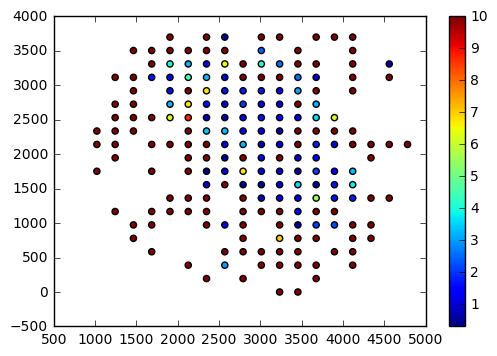

In [10]:
good = np.where(ds != 0)
plt.scatter(xg.ravel()[good], yg.ravel()[good], c=ds[good], vmax=10)
plt.colorbar()

(array([ 51.,  16.,  10.,   2.,   6.,   1.,   1.,   4.,   8.,   2.,   4.,
          5.,   3.,   6.,   2.,   1.,   5.,   3.,   5.,   4.,   7.,   4.,
          5.,   0.,   1.,   1.,   5.,   1.,   2.,   1.,   3.,   2.,   1.,
          2.,   0.,   3.,   1.,   1.,   0.,   0.,   1.,   2.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   2.,   1.,   1.,
          0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([   0.30083581,    1.78124911,    3.2616624 ,    4.7420757 ,
           6.22248899,    7.70290229,    9.18331559,   10.66372888,
          12.14414218,   13.62455548,   15.10496877,   16.58538207,
          18.06579537,   19.54620866,   21.02662196,   22.50703525,
          23.98744855,   25.46786185,   26.948

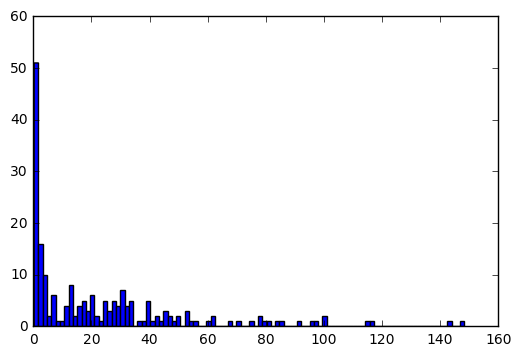

In [11]:
plt.hist(ds[good], bins=100)

In [12]:
wcs = Fisheye(wcs_simple, xg.ravel(), yg.ravel(), xo, yo)

In [13]:
ybc_x, ybc_y = wcs.all_world2pix(az, alt)

In [14]:
alt

array([ 16.83294703,   9.66929617,  19.37721761, ...,   6.82414283,
        26.00180704,  25.54078967])

In [15]:
az

array([ 222.59160791,  236.78310793,  218.12961751, ...,  240.08744489,
        198.91143348,  200.45081243])

In [16]:
np.array([[0,0],[1,0],[0,1],[1,1]]).shape

(4, 2)

In [17]:
np.array([az,alt]).shape

(2, 4314)

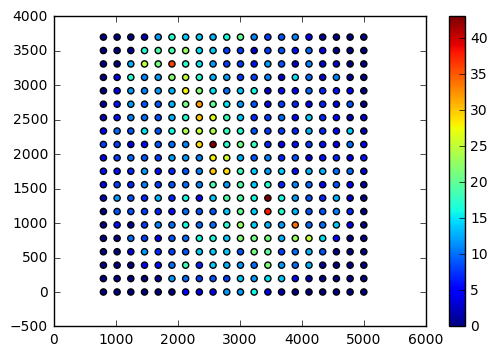

In [18]:
plt.scatter(xg.ravel(), yg.ravel(), c=npts)
plt.colorbar()